# Quantum kernel estimation

## Outline

In this notebook we will carry out these steps several ways to make optimal use of your time on real quantum computers. We will apply a quantum kernel method to

1. A single kernel matrix entry for data with relatively few features, using a real backend, so that we can easily follow what is happening at each step.
2. An entire data set with relatively few features, using a simulated backend, so that we can see how the quantum workstream connects with classical machine learning methods

## Install required packages

In [1]:
%pip install panda
%pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Download data set

In [6]:
import urllib.request

url = "https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv"
urllib.request.urlretrieve(url, "dataset_graph7.csv")

('dataset_graph7.csv', <http.client.HTTPMessage at 0x20c5de93750>)

In [7]:
import pandas as pd
df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.193574,0.113979,-0.005927,0.300957,-0.358603,-0.087866,-0.156226,0.342442,-0.016003,0.143113,0.256422,-0.164125,-0.136743,0.014674,1.0
1,-0.100006,0.002431,0.244218,0.126870,-0.063891,-0.085588,0.072490,0.042986,-0.052714,0.019754,-0.159314,-0.409991,-0.199615,0.053845,-1.0
2,-1.774448,-0.047642,-0.025880,0.252708,-0.350689,-1.604509,-0.114874,0.347631,0.059501,-0.168956,0.351014,-0.128586,0.098897,-0.047799,1.0
3,-0.211585,-0.043782,-1.560226,0.018510,-0.051867,-0.128508,0.218609,-0.075632,-0.183656,-1.715292,-0.105361,-0.300758,-0.566431,0.046542,-1.0
4,-0.105965,0.208387,-0.003896,0.163816,-0.332541,-1.594675,-1.889321,-0.251937,0.374445,-1.431062,0.290588,0.118851,0.048799,-0.073023,1.0


## Single kernel matrix entry

### Step 1: Map classical inputs to a quantum problem

Let's look at the first two data points, which is the minimal needed for calculating the kernel matrix.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

small_data = df.iloc[:2]
small_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.193574,0.113979,-0.005927,0.300957,-0.358603,-0.087866,-0.156226,0.342442,-0.016003,0.143113,0.256422,-0.164125,-0.136743,0.014674,1.0
1,-0.100006,0.002431,0.244218,0.126870,-0.063891,-0.085588,0.072490,0.042986,-0.052714,0.019754,-0.159314,-0.409991,-0.199615,0.053845,-1.0


In [9]:
# Features of the first data point
small_data.values[0,:-1]

array([-0.19357448,  0.11397916, -0.00592673,  0.30095717, -0.35860336,
       -0.08786632, -0.15622592,  0.3424416 , -0.01600324,  0.1431133 ,
        0.25642247, -0.16412547, -0.13674259,  0.01467435])

In [10]:
# Data points with labels removed, for inner product
train_data = small_data.values[:,:-1]
train_data

array([[-0.19357448,  0.11397916, -0.00592673,  0.30095717, -0.35860336,
        -0.08786632, -0.15622592,  0.3424416 , -0.01600324,  0.1431133 ,
         0.25642247, -0.16412547, -0.13674259,  0.01467435],
       [-0.10000625,  0.00243083,  0.24421757,  0.12686991, -0.06389124,
        -0.085588  ,  0.07249021,  0.04298629, -0.0527142 ,  0.01975425,
        -0.15931417, -0.40999085, -0.19961527,  0.05384521]])

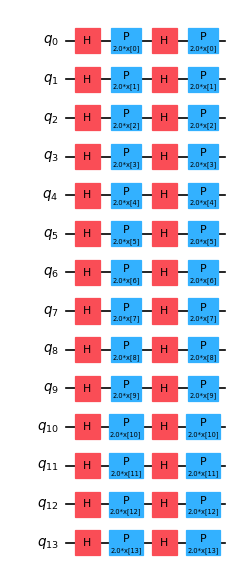

In [11]:
from qiskit.circuit.library import ZFeatureMap

fm = ZFeatureMap(feature_dimension=np.shape(train_data)[1])
fm.decompose().draw("mpl", scale=0.6)

In [12]:
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

circuit depth =  9


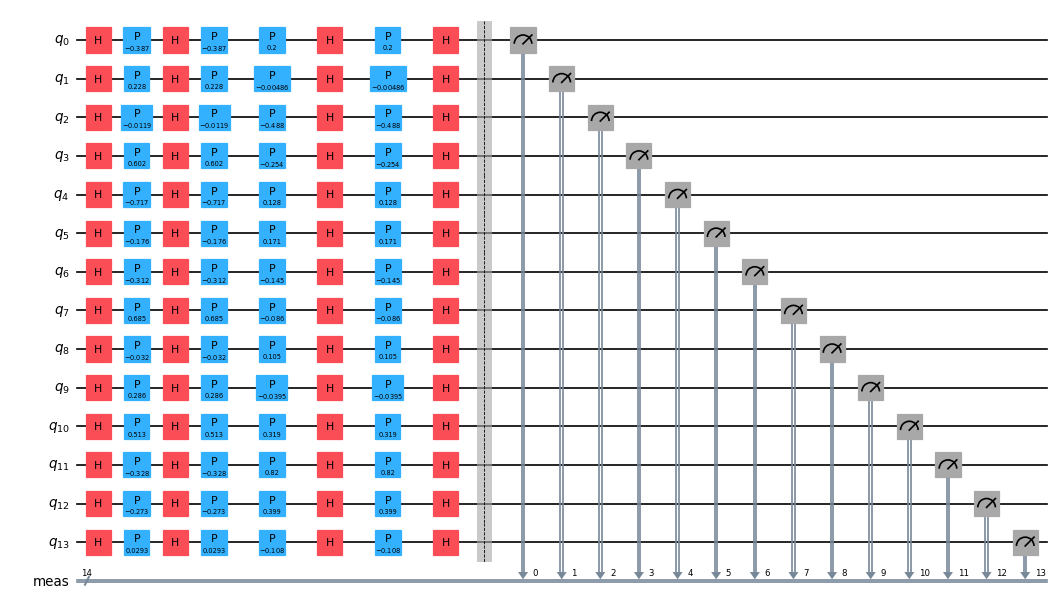

In [13]:
from qiskit.circuit.library import UnitaryOverlap

overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6)

### Step 2: Optimize problem for quantum execution

We start by selecting the least busy backend, then optimize our circuit for running on that backend.

In [14]:
# Import needed packages
from qiskit_ibm_runtime import QiskitRuntimeService

# Get the least busy backend
service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(
#     operational=True, simulator=False, min_num_qubits=fm.num_qubits
# )

backend = service.backend('ibm_strasbourg')  # You can change the backend

print(backend)

C:\Users\dosqas\AppData\Local\Temp\ipykernel_31808\4267002363.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


<IBMBackend('ibm_strasbourg')>


In [15]:
# Apply level 3 optimization to our overlap circuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)

In [16]:
print("circuit depth = ", overlap_ibm.depth())
print(f"{overlap_ibm.depth(lambda x: x.operation.num_qubits == 2)}")
overlap_ibm.draw(idle_wires=False)

circuit depth =  6
0


global phase: 4.2637
            ┌────────────┐┌────┐┌─────────────┐┌────┐ ┌────────────┐ ░       »
 q_11 -> 0 ─┤ Rz(2.2952) ├┤ √X ├┤ Rz(-2.5936) ├┤ √X ├─┤ Rz(1.2743) ├─░───────»
           ┌┴────────────┤├────┤├─────────────┤├────┤┌┴────────────┤ ░ ┌─┐   »
 q_0 -> 13 ┤ Rz(-1.3779) ├┤ √X ├┤ Rz(-2.9475) ├┤ √X ├┤ Rz(-1.9436) ├─░─┤M├───»
           ├─────────────┤├────┤├─────────────┤├────┤├─────────────┤ ░ └╥┘   »
q_13 -> 30 ┤ Rz(-1.6783) ├┤ √X ├┤ Rz(-3.0631) ├┤ √X ├┤ Rz(-1.5415) ├─░──╫────»
           └┬────────────┤├────┤├─────────────┤├────┤└┬────────────┤ ░  ║    »
q_12 -> 34 ─┤ Rz(1.9497) ├┤ √X ├┤ Rz(-3.0094) ├┤ √X ├─┤ Rz(1.3109) ├─░──╫────»
           ┌┴────────────┤├────┤└┬────────────┤├────┤┌┴────────────┤ ░  ║    »
 q_5 -> 36 ┤ Rz(-1.4021) ├┤ √X ├─┤ Rz(-3.137) ├┤ √X ├┤ Rz(-1.7439) ├─░──╫────»
           └┬────────────┤├────┤┌┴────────────┤├────┤└┬────────────┤ ░  ║ ┌─┐»
 q_1 -> 47 ─┤ Rz(1.5659) ├┤ √X ├┤ Rz(-2.9184) ├┤ √X ├─┤ Rz(1.7986) ├─░──╫─┤M├»
            ├───────────┬┘├────┤└┬────────────┤├────┤ ├────────────┤ ░  ║ └╥┘»
 q_8 -> 49 ─┤ Rz(1.676) ├─┤ √X ├─┤ Rz(-3.068) ├┤ √X ├─┤ Rz(1.5388) ├─░──╫──╫─»
            ├───────────┤ ├────┤┌┴────────────┤├────┤ ├────────────┤ ░  ║  ║ »
q_10 -> 59 ─┤ Rz(1.913) ├─┤ √X ├┤ Rz(-2.3803) ├┤ √X ├─┤ Rz(2.1242) ├─░──╫──╫─»
            ├───────────┴┐├────┤├─────────────┤├────┤┌┴────────────┤ ░  ║  ║ »
 q_6 -> 66 ─┤ Rz(-1.719) ├┤ √X ├┤ Rz(-2.6946) ├┤ √X ├┤ Rz(-1.8903) ├─░──╫──╫─»
           ┌┴────────────┤├────┤├─────────────┤├────┤├─────────────┤ ░  ║  ║ »
 q_2 -> 76 ┤ Rz(-2.0606) ├┤ √X ├┤ Rz(-2.6427) ├┤ √X ├┤ Rz(-1.5827) ├─░──╫──╫─»
           └┬────────────┤├────┤├─────────────┤├────┤└┬────────────┤ ░  ║  ║ »
 q_3 -> 77 ─┤ Rz(1.3332) ├┤ √X ├┤ Rz(-2.7692) ├┤ √X ├─┤ Rz(2.1306) ├─░──╫──╫─»
           ┌┴────────────┤├────┤├─────────────┤├────┤┌┴────────────┤ ░  ║  ║ »
 q_4 -> 88 ┤ Rz(-1.4476) ├┤ √X ├┤ Rz(-2.5272) ├┤ √X ├┤ Rz(-2.2573) ├─░──╫──╫─»
           └┬────────────┤├────┤├─────────────┤├────┤└┬────────────┤ ░  ║  ║ »
q_9 -> 119 ─┤ Rz(1.5315) ├┤ √X ├┤ Rz(-2.8935) ├┤ √X ├─┤ Rz(1.8554) ├─░──╫──╫─»
            ├────────────┤├────┤├─────────────┤├────┤ ├────────────┤ ░  ║  ║ »
q_7 -> 121 ─┤ Rz(1.4869) ├┤ √X ├┤ Rz(-2.5261) ├┤ √X ├─┤ Rz(2.2366) ├─░──╫──╫─»
            └────────────┘└────┘└─────────────┘└────┘ └────────────┘ ░  ║  ║ »
  meas: 14/═════════════════════════════════════════════════════════════╩══╩═»
                                                                        0  1 »
«                                      ┌─┐      
« q_11 -> 0 ───────────────────────────┤M├──────
«                                      └╥┘      
« q_0 -> 13 ────────────────────────────╫───────
«                                       ║    ┌─┐
«q_13 -> 30 ────────────────────────────╫────┤M├
«                                       ║ ┌─┐└╥┘
«q_12 -> 34 ────────────────────────────╫─┤M├─╫─
«                    ┌─┐                ║ └╥┘ ║ 
« q_5 -> 36 ─────────┤M├────────────────╫──╫──╫─
«                    └╥┘                ║  ║  ║ 
« q_1 -> 47 ──────────╫─────────────────╫──╫──╫─
«                     ║       ┌─┐       ║  ║  ║ 
« q_8 -> 49 ──────────╫───────┤M├───────╫──╫──╫─
«                     ║       └╥┘   ┌─┐ ║  ║  ║ 
«q_10 -> 59 ──────────╫────────╫────┤M├─╫──╫──╫─
«                     ║ ┌─┐    ║    └╥┘ ║  ║  ║ 
« q_6 -> 66 ──────────╫─┤M├────╫─────╫──╫──╫──╫─
«           ┌─┐       ║ └╥┘    ║     ║  ║  ║  ║ 
« q_2 -> 76 ┤M├───────╫──╫─────╫─────╫──╫──╫──╫─
«           └╥┘┌─┐    ║  ║     ║     ║  ║  ║  ║ 
« q_3 -> 77 ─╫─┤M├────╫──╫─────╫─────╫──╫──╫──╫─
«            ║ └╥┘┌─┐ ║  ║     ║     ║  ║  ║  ║ 
« q_4 -> 88 ─╫──╫─┤M├─╫──╫─────╫─────╫──╫──╫──╫─
«            ║  ║ └╥┘ ║  ║     ║ ┌─┐ ║  ║  ║  ║ 
«q_9 -> 119 ─╫──╫──╫──╫──╫─────╫─┤M├─╫──╫──╫──╫─
«            ║  ║  ║  ║  ║ ┌─┐ ║ └╥┘ ║  ║  ║  ║ 
«q_7 -> 121 ─╫──╫──╫──╫──╫─┤M├─╫──╫──╫──╫──╫──╫─
«            ║  ║  ║  ║  ║ └╥┘ ║  ║  ║  ║  ║  ║ 
«  meas: 14/═╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
«            2  3  4  5  6  7  8  9  10 11 12 13

### Step 3: Execute using Qiskit Runtime Primitives

The syntax for running on a simulator is commented out below. For this dataset, with a small number of features, running on a simulator is still an option. For utility-scale calculations, simulation is not typically feasible. Simulators should only be used to debug scaled-down code.

In [18]:
# Run this for a simulator
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import Options, Session, Sampler

num_shots = 10000

# Evaluate the problem using state vector-based primitives from Qiskit
sampler = StatevectorSampler()
job = sampler.run([overlap_circ], shots=num_shots)
results = job.result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()

### Step 4: Post-process, return result in classical format

As described in the introduction, the most useful measurement here is the probability of measuring the all zero state ∣000...00⟩.

In [19]:
counts_bit.get('0'*len(train_data[0]))/num_shots

0.5484

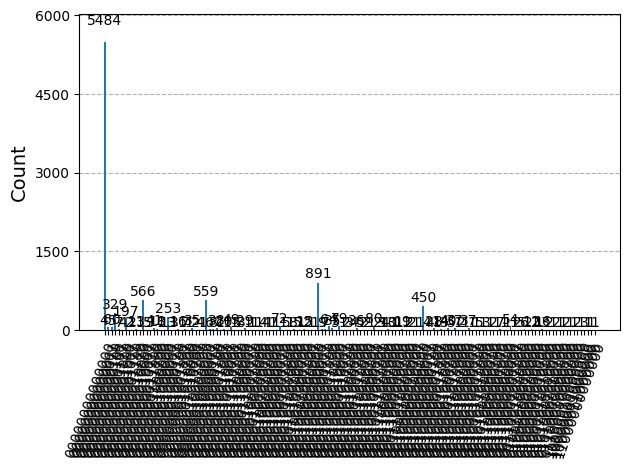

In [21]:
from qiskit.visualization import plot_histogram
plot_histogram(counts_bit)

It's hard to read with too many bitstrings. Let's use the following functions to show the top 10 bitstrings.

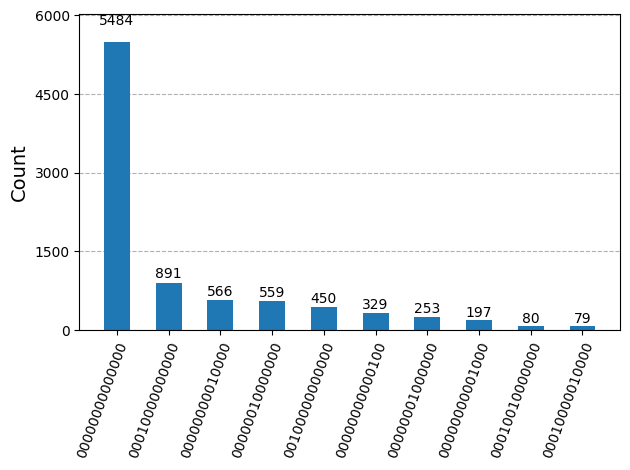

In [22]:
plot_histogram(data=counts_bit, sort='value_desc', number_to_keep=10)

## Full kernel matrix

Let's move on to calculating the full kernel matrix

### Step 1: Map classical inputs to a quantum problem

In [23]:
# Total number of data points in this data set
len(df)

128

Let's divide the data set into training data and testing data. 

In [24]:
# Prepare training data
train_size = 30
X_train=df.values[0:train_size,:-1]
train_labels = df.values[0:train_size,-1]

# Prepare testing data
test_size = 10
X_test=df.values[train_size:train_size+test_size,:-1]
test_labels=df.values[train_size:train_size+test_size,-1]

In [25]:
# Create empty kernel matrix
num_samples = np.shape(X_train)[0]
num_samples

30

In [26]:
kernel_matrix = np.full((num_samples, num_samples), np.nan)
print(kernel_matrix.shape)
kernel_matrix

(30, 30)


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [27]:
test_matrix = np.full((test_size, num_samples), np.nan)
print(test_matrix.shape)
test_matrix

(10, 30)


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [28]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
print(f"Number of features: {num_features}")
print(f"Number of qubits: {num_qubits}")

Number of features: 14
Number of qubits: 7


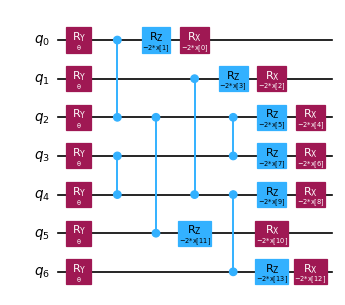

In [29]:
# To use a custom feature map use the lines below.

entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

fm.draw("mpl", scale=0.6)

### Step 2 & 3: Optimize problem & execute using primitives

In [30]:
def create_training_overlap_circuit_list(train_size, X_train, feature_map):
    training_overlap_circ_list = [
        UnitaryOverlap(
            feature_map.assign_parameters(list(X_train[x1]) + [np.pi / 2]),
            feature_map.assign_parameters(list(X_train[x2]) + [np.pi / 2])
        )
        for x1 in range(train_size) for x2 in range(x1 + 1, train_size)
    ]

    for circuit in training_overlap_circ_list:
        circuit.measure_all()

    return training_overlap_circ_list


def create_testing_overlap_circuit_list(test_size, train_size, X_test, X_train, feature_map):
    testing_overlap_circ_list = [
        UnitaryOverlap(
            feature_map.assign_parameters(list(X_test[x1]) + [np.pi / 2]),
            feature_map.assign_parameters(list(X_train[x2]) + [np.pi / 2])
        )
        for x1 in range(test_size) for x2 in range(train_size)
    ]

    for circuit in testing_overlap_circ_list:
        circuit.measure_all()

    return testing_overlap_circ_list


def compute_overlap_matrix(results, size1, size2, is_symmetric=False):
    """
    Compute the kernel or test matrix from the sampler results.

    Parameters:
    - results: The result object from sampler.run()
    - size1: Number of rows in the matrix (train_size or test_size)
    - size2: Number of columns in the matrix (train_size)
    - is_symmetric: If True, fills a symmetric kernel matrix.

    Returns:
    - A numpy array representing the computed overlap matrix.
    """
    overlap_matrix = np.zeros((size1, size2))
    idx = 0

    for x1 in range(size1):
        for x2 in range(x1 + 1, size2) if is_symmetric else range(size2):
            counts = results[idx].data.meas.get_int_counts()
            prob_0 = counts.get(0, 0.0) / num_shots

            overlap_matrix[x1, x2] = prob_0

            if is_symmetric:
                overlap_matrix[x2, x1] = prob_0  # Mirror value for symmetry

            idx += 1

        if is_symmetric:
            overlap_matrix[x1, x1] = 1  # Diagonal elements should be 1 for training data

    return overlap_matrix

In [31]:
# Running on a simulator
from qiskit.primitives import StatevectorSampler

# Evaluate the problem using state vector-based primitives from Qiskit.
sampler = StatevectorSampler()
num_shots = 10000

In [26]:
# # Running on a real hardware
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# sampler = Sampler(mode=backend)

Create training circutis and submit job

In [32]:
training_overlap_circ_list = create_training_overlap_circuit_list(train_size, X_train, fm)
job_training = sampler.run(training_overlap_circ_list, shots=num_shots)

Create testing circuits and submit job

In [33]:
testing_overlap_circ_list = create_testing_overlap_circuit_list(test_size, train_size, X_test, X_train, fm)
job_testing = sampler.run(testing_overlap_circ_list, shots=num_shots)

Compute training kernel matrix

In [34]:
results_training = job_training.result()
kernel_matrix = compute_overlap_matrix(results_training, train_size, train_size, is_symmetric=True)
print("Training matrix done")

Training matrix done


Compute test matrix

In [35]:
results_testing = job_testing.result()
test_matrix = compute_overlap_matrix(results_testing, test_size, train_size, is_symmetric=False)
print("Test matrix done")

Test matrix done


#### Running on real hardware

In [31]:
# # Running on a real hardware
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# sampler = Sampler(mode=backend)

Create training circutis and submit job

In [32]:
# training_overlap_circ_list = create_training_overlap_circuit_list(train_size, X_train, fm)
# pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
# isa_circuit_list = [pm.run(circuit) for circuit in training_overlap_circ_list]

In [33]:
# job_training = sampler.run(isa_circuit_list, shots=num_shots)

Create testing circuits and submit job

In [34]:
# testing_overlap_circ_list = create_testing_overlap_circuit_list(test_size, train_size, X_test, X_train, fm)
# isa_circuit_list = [pm.run(circuit) for circuit in testing_overlap_circ_list]

In [35]:
# job_testing = sampler.run(isa_circuit_list, shots=num_shots)

Compute training kernel matrix

In [36]:
# results_training = job_training.result()
# kernel_matrix = compute_overlap_matrix(results_training, train_size, train_size, is_symmetric=True)
# print("Training matrix done")

Compute test matrix

In [37]:
# results_testing = job_testing.result()
# test_matrix = compute_overlap_matrix(results_testing, test_size, train_size, is_symmetric=False)
# print("Test matrix done")

### Step 4: Post-process, return result in classical format

In [38]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC

#Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

In [39]:
# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)

SVC(kernel='precomputed')

In [40]:
qml_svc.predict(test_matrix)

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.])

In [41]:
test_labels

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.])

In [42]:
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


## Further reading

If you want to learn more about Quantum Machine Learning, check out [the QML course](https://learning.quantum.ibm.com/course/quantum-machine-learning) on IBM Quantum Learning platform.

### Step 1: Map classical inputs to a quantum problem

In [43]:
#Two mock data points, including category labels, as in training

large_data = [
    [-0.028,	-1.49,	-1.698,	0.107,	-1.536,	-1.538,	-1.356,	-1.514,	-0.109,	-1.8,	-0.122,	-1.651,	-1.955,	-0.123,	-1.732,	0.091,	-0.048,	-0.128,	-0.026,	0.082,	-1.263,	0.065,	0.004,	-0.055,	-0.08,	-0.173,	-1.734,	-0.39,	-1.451,	0.078,	-1.578,	-0.025,	-0.184,	-0.119,	-1.336,	0.055,	-0.204,	-1.578,	0.132,	-0.121,	-1.599,	-0.187,-1],
    [-1.414,	-1.439,	-1.606,	0.246,	-1.673,	0.002,	-1.317,	-1.262,	-0.178,	-1.814,	0.013,	-1.619,	-1.86,	-0.25,	-0.212,	-0.214,	-0.033,	0.071,	-0.11,	-1.607,	0.441,	-0.143,	-0.009,	-1.655,	-1.579,	0.381,	-1.86,	-0.079,	-0.088,	-0.058,	-1.481,	-0.064,	-0.065,	-1.507,	0.177,	-0.131,	-0.153,	0.07,	-1.627,	0.593,	-1.547,	-0.16,-1]
]
train_data = [large_data[0][:-1],large_data[1][:-1]]

In [44]:
from qiskit.circuit.library import ZZFeatureMap

fm = ZZFeatureMap(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)

unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

In [45]:
from qiskit.circuit.library import UnitaryOverlap

overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose(reps = 2).depth())
print("two-qubit depth", overlap_circ.decompose().depth(lambda instr: len(instr.qubits) > 1))
#overlap_circ.draw("mpl", scale=0.6, style="iqp")

circuit depth =  251
two-qubit depth 165


In [46]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# Prepare feature map for computing overlap

entangler_map = [    [3, 4], [2, 5], [1, 4], [2, 3], [4, 6], [7, 9], [10, 11], [9, 12], [8, 11], [9, 10], [11, 13], [14, 16], [17, 18], [16, 19], [15, 18], [16, 17], [18, 20]
]

In [47]:
#Use the entangler map above to build a feature map

num_features = np.shape(train_data)[1]
num_qubits = int(num_features / 2)

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

In [48]:
# Assign features of each data point to a unitary, an instance of the general feature map.

unitary1 = fm.assign_parameters(list(train_data[0])+ [np.pi / 2] )
unitary2 = fm.assign_parameters(list(train_data[1])+ [np.pi / 2] )

from qiskit.circuit.library import UnitaryOverlap

# Create the overlap circuit
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

### Step 2: Optimize problem for quantum execution

In [49]:
#Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Get the least busy backend
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

C:\Users\dosqas\AppData\Local\Temp\ipykernel_31808\2213210671.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


<IBMBackend('ibm_strasbourg')>


In [50]:
#Apply level 3 optimization to our overlap circuit
transpiled_qcs=[]
transpiled_depths=[]
transpiled_twoqubit_depths=[]
for i in range(1,20):
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    overlap_ibm = pm.run(overlap_circ)
    transpiled_qcs.append(overlap_ibm)
    transpiled_depths.append(overlap_ibm.decompose().depth())
    transpiled_twoqubit_depths.append(overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1))

print("circuit depth = ", overlap_ibm.decompose().depth())

circuit depth =  69


In [51]:
print(transpiled_depths)
print(transpiled_twoqubit_depths)

[69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [52]:
overlap_ibm = transpiled_qcs[1]

### Step 3: Execute using Qiskit Runtime Primitives

In [53]:
#Run on ibm_osaka, 7-12-24, required 22 sec.

#Import our runtime primitive
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

#Open a Runtime session:
session = Session(backend=backend)
num_shots = 10000
# Use sampler and get the counts

sampler = Sampler(mode=session)
options = sampler.options
options.dynamical_decoupling.enable = True
options.twirling.enable_gates = True
counts = (
        sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

# Close session after done
session.close()

### Step 4: Post-process, return result in classical format

In [54]:
counts.get(0, 0.0)/num_shots

0.0054